In [1]:
import tensorflow as tf 
import numpy as np 
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

In [2]:
(X_train, Y_train), (X_val, Y_val) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
X_train_imb = np.load('../input/dataset-all/x_train_imbalanced.npy')
y_train_balanced_asym = np.load('../input/dataset-all/y_train_balanced_asym.npy')
y_train_balanced_sym = np.load('../input/dataset-all/y_train_balanced_sym.npy')
y_train_imbalanced = np.load('../input/dataset-all/y_train_imbalanced.npy')
y_train_imbalanced_asym = np.load('../input/dataset-all/y_train_imbalanced_asym.npy')
y_train_imbalanced_sym = np.load('../input/dataset-all/y_train_imbalanced_sym.npy')

In [4]:
def plot_fig(X, y):
    plt.figure(figsize=(20,4))
    for index, (image, label) in enumerate(zip(X[0:5], y[0:5])):
        plt.subplot(1, 5, index + 1)
        plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
        plt.title('Training: %i\n' % int(label), fontsize = 20)

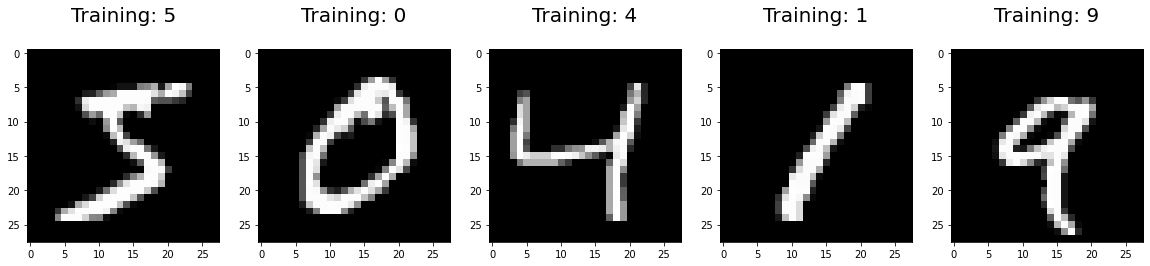

In [5]:
plot_fig(X_train, Y_train)

In [6]:
def check_class_distribution(y_train):
    class_frq = {}
    for val in y_train:
        if class_frq.get(val) is not None:
            class_frq[val] = class_frq.get(val) +1
        else:
            class_frq[val] = 1
    class_frq
    
    return class_frq

In [7]:
print("Class Distribution: ", check_class_distribution(y_train_imbalanced))

Class Distribution:  {5: 4378, 0: 2385, 4: 2384, 1: 5387, 9: 4738, 3: 4931, 7: 4999, 8: 2353, 6: 2401, 2: 2388}


In [8]:
def preprocess_data(x_train, y_train, x_val, y_val):
    """
    Return nomalized X and one-hot encoded Y-label 
    """
    # expand new axis, channel axis 
    x_train = np.expand_dims(x_train, axis=-1)
    # [optional]: we may need 3 channel (instead of 1)
    x_train = np.repeat(x_train, 3, axis=-1)
    # it's always better to normalize 
    x_train = x_train.astype('float32') / 255
    # resize the input shape , i.e. old shape: 28, new shape: 32
    x_train = tf.image.resize(x_train, [32,32]) # if we want to resize 
    
    x_val = np.expand_dims(x_val, axis=-1)
    x_val = np.repeat(x_val, 3, axis=-1)
    x_val = x_val.astype('float32') / 255
    x_val = tf.image.resize(x_val, [32,32]) # if we want to resize 
    
    # one hot 
    y_train = tf.keras.utils.to_categorical(y_train , num_classes=10)
    y_val = tf.keras.utils.to_categorical(y_val , num_classes=10)

    return x_train, y_train, x_val, y_val

In [9]:
x_train, y_train, x_val, y_val = preprocess_data(X_train, Y_train,X_val, Y_val)

2021-11-29 02:28:33.550064: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 02:28:33.656383: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 02:28:33.657146: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-29 02:28:33.659633: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [10]:
x_train_ub, y_train_ub, x_val_ub, y_val_ub = preprocess_data(X_train_imb, y_train_imbalanced, X_val, Y_val)

In [11]:
x_train_sym, y_train_sym, x_val_sym, y_val_sym = preprocess_data(X_train, y_train_balanced_sym, X_val, Y_val)

In [12]:
x_train_ub_sym, y_train_ub_sym, x_val_ub_sym, y_val_ub_sym = preprocess_data(X_train_imb, y_train_imbalanced_sym, X_val, Y_val)

In [13]:
x_train_asym, y_train_asym, x_val_asym, y_val_asym = preprocess_data(X_train, y_train_balanced_asym,X_val, Y_val)

In [14]:
x_train_ub_asym, y_train_ub_asym, x_val_ub_asym, y_val_ub_asym = preprocess_data(X_train_imb, y_train_imbalanced_asym,X_val, Y_val)

In [15]:
class LDAMLoss():

    def __init__(self, cls_num_list, max_m=0.5, weight=None, s=30):
        super(LDAMLoss, self).__init__()
        m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list)+0.000005)
        m_list = m_list * (max_m / np.max(m_list))
        m_list = tf.convert_to_tensor(m_list, dtype=tf.float32)
        self.m_list = m_list
        assert s > 0
        self.s = s
        self.weight = weight
        self.n_classes = len(cls_num_list)

    def __call__(self, target, x):
        index_float = target

        batch_m = tf.matmul(self.m_list[None, :], tf.transpose(index_float))
        batch_m = tf.reshape(batch_m, (-1, 1))
        x_m = x - batch_m

        # if condition is true, return x_m[index], otherwise return x[index]
        index_bool = tf.cast(index_float, tf.bool)
        output = tf.where(index_bool, x_m, x)

        labels = index_float
        logits = output

        loss = tf.nn.softmax_cross_entropy_with_logits(
            labels=labels, logits=logits*self.s)
        return tf.reduce_mean(loss)

In [41]:
def model_with_LDAM(x_train, y_train, x_val=None, y_val=None):
    
    input = tf.keras.Input(shape=(32,32,3))
    base_model = tf.keras.applications.ResNet50(input_tensor=input, include_top=False)
    output = base_model.output
    output = tf.keras.layers.GlobalAveragePooling2D()(output)
    predictions =tf.keras.layers.Dense(10, activation='softmax')(output)
    
    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=LDAMLoss([0,1,2,3,4,5,6,7,8,9]),
              metrics=['accuracy', tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),
                       tfa.metrics.F1Score(10),tf.keras.metrics.AUC()])

    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, verbose = 2, batch_size=64)
    

In [42]:
model_with_LDAM(x_train_ub, y_train_ub, x_val_ub, y_val_ub) # training on unbalanced data

Epoch 1/10
568/568 - 31s - loss: 0.5380 - accuracy: 0.9225 - precision_4: 0.9841 - recall_4: 0.4937 - f1_score: 0.9154 - auc_4: 0.9868 - val_loss: 3.7244 - val_accuracy: 0.1913 - val_precision_4: 1.0000 - val_recall_4: 0.0856 - val_f1_score: 0.0932 - val_auc_4: 0.6510
Epoch 2/10
568/568 - 25s - loss: 0.1526 - accuracy: 0.9756 - precision_4: 0.9976 - recall_4: 0.5275 - f1_score: 0.9733 - auc_4: 0.9981 - val_loss: 0.3195 - val_accuracy: 0.9553 - val_precision_4: 0.9992 - val_recall_4: 0.2510 - val_f1_score: 0.9556 - val_auc_4: 0.9966
Epoch 3/10
568/568 - 25s - loss: 0.1154 - accuracy: 0.9815 - precision_4: 0.9982 - recall_4: 0.5513 - f1_score: 0.9800 - auc_4: 0.9987 - val_loss: 0.3221 - val_accuracy: 0.9704 - val_precision_4: 1.0000 - val_recall_4: 0.4067 - val_f1_score: 0.9698 - val_auc_4: 0.9979
Epoch 4/10
568/568 - 25s - loss: 0.1043 - accuracy: 0.9829 - precision_4: 0.9985 - recall_4: 0.5398 - f1_score: 0.9816 - auc_4: 0.9989 - val_loss: 0.1017 - val_accuracy: 0.9827 - val_precision_

In [48]:
# Best Evaluation Metric Parameters:  unbalanced data

# acccuracy: 0.9889  precision: 0.9991 recall: 0.6937 f1_score: 0.9888  auc_4: 0.9996


In [43]:
model_with_LDAM(x_train, y_train, x_val, y_val) # training on balance dataset (default MNIST dataset)

Epoch 1/10
938/938 - 46s - loss: 0.4051 - accuracy: 0.9375 - precision_5: 0.9900 - recall_5: 0.4663 - f1_score: 0.9369 - auc_5: 0.9909 - val_loss: 0.2657 - val_accuracy: 0.9479 - val_precision_5: 0.9889 - val_recall_5: 0.2142 - val_f1_score: 0.9470 - val_auc_5: 0.9935
Epoch 2/10
938/938 - 40s - loss: 0.1205 - accuracy: 0.9803 - precision_5: 0.9982 - recall_5: 0.5088 - f1_score: 0.9802 - auc_5: 0.9985 - val_loss: 0.1149 - val_accuracy: 0.9805 - val_precision_5: 0.9969 - val_recall_5: 0.6520 - val_f1_score: 0.9804 - val_auc_5: 0.9982
Epoch 3/10
938/938 - 40s - loss: 0.1149 - accuracy: 0.9824 - precision_5: 0.9979 - recall_5: 0.5296 - f1_score: 0.9823 - auc_5: 0.9986 - val_loss: 0.0527 - val_accuracy: 0.9913 - val_precision_5: 0.9994 - val_recall_5: 0.6954 - val_f1_score: 0.9912 - val_auc_5: 0.9996
Epoch 4/10
938/938 - 39s - loss: 0.1145 - accuracy: 0.9809 - precision_5: 0.9983 - recall_5: 0.5394 - f1_score: 0.9808 - auc_5: 0.9987 - val_loss: 0.0459 - val_accuracy: 0.9902 - val_precision_

In [ ]:
# Best Evaluation Metric Parameters: balance dataset (default MNIST dataset)

# accuracy: 0.9913  precision: 0.9994  recall: 0.6954  f1_score: 0.9912  auc: 0.9996


In [44]:
model_with_LDAM(x_train_sym, y_train_sym, x_val_sym, y_val_sym) # training on balance symetric dataset

Epoch 1/10
938/938 - 46s - loss: 4.2997 - accuracy: 0.2417 - precision_6: 0.1777 - recall_6: 0.0059 - f1_score: 0.2157 - auc_6: 0.6398 - val_loss: 3.4341 - val_accuracy: 0.1892 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_f1_score: 0.0766 - val_auc_6: 0.6902
Epoch 2/10
938/938 - 40s - loss: 4.3179 - accuracy: 0.2500 - precision_6: 0.2602 - recall_6: 0.0117 - f1_score: 0.2222 - auc_6: 0.6444 - val_loss: 4.0180 - val_accuracy: 0.0994 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - val_f1_score: 0.0298 - val_auc_6: 0.5299
Epoch 3/10
938/938 - 39s - loss: 4.2201 - accuracy: 0.2144 - precision_6: 0.1021 - recall_6: 0.0023 - f1_score: 0.1812 - auc_6: 0.6318 - val_loss: 3.6742 - val_accuracy: 0.3278 - val_precision_6: 0.1048 - val_recall_6: 0.0013 - val_f1_score: 0.2668 - val_auc_6: 0.7626
Epoch 4/10
938/938 - 40s - loss: 3.9152 - accuracy: 0.2900 - precision_6: 0.3102 - recall_6: 0.0088 - f1_score: 0.2655 - auc_6: 0.6810 - val_loss: 3.3726 - val_accuracy: 0.4374 

In [ ]:
# Best Evaluation Metric Parameters: balance symetric dataset

# accuracy: 0.7883  precision: 0.9936  recall_6: 0.0155  f1_score: 0.7761  auc: 0.9674

In [45]:
model_with_LDAM(x_train_ub_sym, y_train_ub_sym, x_val_ub_sym, y_val_ub_sym) #training on unbalance symetric dataset

Epoch 1/10
568/568 - 32s - loss: 3.7853 - accuracy: 0.3166 - precision_7: 0.0970 - recall_7: 0.0030 - f1_score: 0.2028 - auc_7: 0.6802 - val_loss: 27.0787 - val_accuracy: 0.0981 - val_precision_7: 0.0981 - val_recall_7: 0.0981 - val_f1_score: 0.0180 - val_auc_7: 0.4989
Epoch 2/10
568/568 - 25s - loss: 3.5425 - accuracy: 0.2996 - precision_7: 0.1251 - recall_7: 0.0029 - f1_score: 0.1837 - auc_7: 0.6869 - val_loss: 3.4696 - val_accuracy: 0.3471 - val_precision_7: 0.3333 - val_recall_7: 0.0026 - val_f1_score: 0.2548 - val_auc_7: 0.7290
Epoch 3/10
568/568 - 25s - loss: 3.7151 - accuracy: 0.3211 - precision_7: 0.0870 - recall_7: 0.0025 - f1_score: 0.2001 - auc_7: 0.6951 - val_loss: 6.5329 - val_accuracy: 0.2079 - val_precision_7: 0.0684 - val_recall_7: 0.0079 - val_f1_score: 0.1365 - val_auc_7: 0.5709
Epoch 4/10
568/568 - 25s - loss: 3.4464 - accuracy: 0.4083 - precision_7: 0.1124 - recall_7: 0.0027 - f1_score: 0.2684 - auc_7: 0.7261 - val_loss: 3.3920 - val_accuracy: 0.4503 - val_precision

In [ ]:
# Best Evaluation Metric Parameters:  unbalance symetric dataset

#accuracy: 0.5165  precision: 0.0997 recall: 0.0031  val_f1_score: 0.4439  val_auc: 0.8397

In [46]:
model_with_LDAM(x_train_asym, y_train_asym, x_val_asym, y_val_asym) #training on balance asymetric dataset

Epoch 1/10
938/938 - 46s - loss: 1.1189 - accuracy: 0.7167 - precision_8: 0.9505 - recall_8: 0.2433 - f1_score: 0.7024 - auc_8: 0.9606 - val_loss: 0.6318 - val_accuracy: 0.8546 - val_precision_8: 0.9992 - val_recall_8: 0.1307 - val_f1_score: 0.8432 - val_auc_8: 0.9736
Epoch 2/10
938/938 - 39s - loss: 0.4649 - accuracy: 0.7741 - precision_8: 0.9966 - recall_8: 0.3024 - f1_score: 0.7661 - auc_8: 0.9824 - val_loss: 0.3073 - val_accuracy: 0.9844 - val_precision_8: 0.9985 - val_recall_8: 0.3919 - val_f1_score: 0.9844 - val_auc_8: 0.9882
Epoch 3/10
938/938 - 39s - loss: 0.5401 - accuracy: 0.7747 - precision_8: 0.9898 - recall_8: 0.3164 - f1_score: 0.7679 - auc_8: 0.9802 - val_loss: 28.0829 - val_accuracy: 0.1135 - val_precision_8: 0.1135 - val_recall_8: 0.1135 - val_f1_score: 0.0204 - val_auc_8: 0.5075
Epoch 4/10
938/938 - 40s - loss: 0.8258 - accuracy: 0.7092 - precision_8: 0.9856 - recall_8: 0.1778 - f1_score: 0.6915 - auc_8: 0.9646 - val_loss: 0.4401 - val_accuracy: 0.8240 - val_precision

In [ ]:
# Best Evaluation Metric Parameters: balance asymetric dataset

#accuracy: 0.9844 precision: 0.9985 recall: 0.3919 f1_score: 0.9844  auc: 0.9882

In [47]:
model_with_LDAM(x_train_ub_asym, y_train_ub_asym, x_val_ub_asym, y_val_ub_asym) #training on unbalance asymetric dataset

Epoch 1/10
568/568 - 31s - loss: 1.1511 - accuracy: 0.6967 - precision_9: 0.9538 - recall_9: 0.2451 - f1_score: 0.6829 - auc_9: 0.9578 - val_loss: 3.3882 - val_accuracy: 0.2537 - val_precision_9: 1.0000 - val_recall_9: 9.0000e-04 - val_f1_score: 0.1765 - val_auc_9: 0.7592
Epoch 2/10
568/568 - 25s - loss: 0.5365 - accuracy: 0.7546 - precision_9: 0.9948 - recall_9: 0.2850 - f1_score: 0.7474 - auc_9: 0.9797 - val_loss: 0.4399 - val_accuracy: 0.9527 - val_precision_9: 0.9923 - val_recall_9: 0.2442 - val_f1_score: 0.9522 - val_auc_9: 0.9811
Epoch 3/10
568/568 - 25s - loss: 0.4847 - accuracy: 0.7633 - precision_9: 0.9956 - recall_9: 0.2925 - f1_score: 0.7580 - auc_9: 0.9807 - val_loss: 0.3576 - val_accuracy: 0.9675 - val_precision_9: 0.9952 - val_recall_9: 0.4106 - val_f1_score: 0.9665 - val_auc_9: 0.9865
Epoch 4/10
568/568 - 25s - loss: 0.4933 - accuracy: 0.7605 - precision_9: 0.9943 - recall_9: 0.2893 - f1_score: 0.7566 - auc_9: 0.9804 - val_loss: 0.3777 - val_accuracy: 0.9593 - val_precis

In [ ]:
# Best Evaluation Metric Parameters:  unbalance asymetric dataset

# accuracy: 0.9698  precision: 0.9981 recall: 0.3082 f1_score: 0.9684 auc: 0.9898